In [98]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from tqdm import tqdm
import shap

# Load Data

In [2]:
# classifiers = pd.read_csv('classifiers.csv', sep=';')
subjects = pd.read_csv('data/subjects.csv', sep=';', encoding='windows-1251')

diagnosticresults = pd.read_csv('data/diagnosticresults.csv', sep=';').drop(['Partition'], axis=1)
diagnosticresultdetails = pd.read_csv('data/diagnosticresultdetails.csv', sep=';').drop(['Partition'], axis=1)

egeresults = pd.read_csv('data/egeresults.csv', sep=';').drop(['Partition'], axis=1)
egeresultdetails = pd.read_csv('data/egeresultdetails.csv', sep=';')
for i in range(2, 14):
    egeresultdetails = pd.concat([egeresultdetails, 
                                  pd.read_csv('data/egeresultdetails{}.csv'.format(i), sep=';')])
egeresultdetails = egeresultdetails.drop(['Partition'], axis=1)

medalistresults = pd.read_csv('data/medalistresults.csv', sep=';').drop(['Partition'], axis=1)
medalistsubjects = pd.read_csv('data/medalistsubjects.csv', sep=';').drop(['Partition'], axis=1)

participants = pd.read_csv('data/participants.csv', sep=';').drop(['Partition'], axis=1)

selfdiagnosticresults = pd.read_csv('data/selfdiagnosticresults.csv', sep=';').drop(['Partition'], axis=1)
selfdiagnosticresultdetails = pd.DataFrame()
for i in range(6):
    selfdiagnosticresultdetails = pd.concat([selfdiagnosticresultdetails, 
                                  pd.read_csv('data/selfdiagnosticresultdetails{}.csv'.format(i), sep=';')])
selfdiagnosticresultdetails = selfdiagnosticresultdetails.drop(['Partition'], axis=1)

# EDA

## Columns Description

### Diagnostic
добавить к диагностике процент оценки, как для егэ

In [47]:
# on ResultID

In [48]:
diagnosticresults.head()

,ResultId,Source,ParticipantId,StudentParallel,TestDate,Mark,MaxMark,SubjectId
0,187000,0,C70E4C52-34C9-4FBE-9B52-4B78AE43C2DA,11,2019-11-08 16:52:48,25.0,33.0,75
1,239604,0,20647873-4AA8-42E3-B7FE-51DE8E0BEAF5,11,2020-03-20 15:04:34,12.0,30.0,77
2,239606,0,4DFEFA69-EB35-44BD-B239-6AA4DE66F866,11,2020-03-20 15:06:20,24.0,31.0,86
3,239611,0,B4816FC2-CAF4-47EE-8AC7-73E32767E771,11,2020-03-20 15:16:21,27.0,31.0,86
4,239636,0,DFCBA91A-0BE5-4EB9-899E-D0166882F392,11,2020-03-23 10:01:31,26.0,31.0,9


In [49]:
diagnosticresultdetails.head()

,Id,ResultId,Source,NumberInKim,Mark,MaxMark,ClassifierId
0,3151177,187000,0,1,0.0,2.0,1883
1,3151178,187000,0,2,1.0,1.0,2579
2,3151179,187000,0,3,1.0,1.0,2894
3,3151180,187000,0,4,0.0,1.0,8855
4,3151181,187000,0,5,1.0,1.0,8475


In [50]:
# В details содержатся данные по каждой задаче для конкретного результата
diagnosticresultdetails[diagnosticresultdetails.ResultId == 187000]

,Id,ResultId,Source,NumberInKim,Mark,MaxMark,ClassifierId
0,3151177,187000,0,1,0.0,2.0,1883
1,3151178,187000,0,2,1.0,1.0,2579
2,3151179,187000,0,3,1.0,1.0,2894
3,3151180,187000,0,4,0.0,1.0,8855
4,3151181,187000,0,5,1.0,1.0,8475
5,3151182,187000,0,6,1.0,1.0,9082
6,3151183,187000,0,7,4.0,5.0,9242
7,3151184,187000,0,8,1.0,1.0,8583
8,3151185,187000,0,9,1.0,1.0,8003
9,3151186,187000,0,10,1.0,1.0,9108


### Ege

In [51]:
egeresults.head()

,Id,ParticipantId,DateExam,MarkPercent,SubjectId
0,000176B3-FD22-464F-80E4-1903332D8EFF,74A04FC2-A13B-468F-B4FF-08D4A3DDCEEA,2020-07-16,75,86
1,0007FBF5-CECE-4769-AAA4-F8D3B54460DE,4C5F3B22-6439-4255-83A3-9C2573607F96,2020-07-20,77,9
2,0008DF1B-A868-4A0E-AFEC-3F5F3EDB3D5D,539BF0E1-24D7-4323-8B36-EECAC7B5C0C5,2020-07-03,25,27
3,000CBD0B-5513-4F9D-9E31-1BA125B9472B,1BAE7BE4-5C78-4E0D-B29D-7E06454C830B,2020-07-13,83,77
4,000F3DEE-44BF-40C9-8D0F-DB86C15A16E3,5B3D82FB-D840-44DE-ADC0-A9CBEB2C06B2,2020-07-20,91,4


In [52]:
egeresultdetails.head()

,Id,ResultId,Part,NumberInPart,Number,Mark,MaxMark,ClassifierId
0,39,4EF9DB0D-2E75-4654-A74C-0000317B2FC1,1,1,0,1,1,3914
1,40,4EF9DB0D-2E75-4654-A74C-0000317B2FC1,1,2,0,1,1,1252
2,41,4EF9DB0D-2E75-4654-A74C-0000317B2FC1,1,3,0,1,1,498
3,42,4EF9DB0D-2E75-4654-A74C-0000317B2FC1,1,4,0,1,1,498
4,43,4EF9DB0D-2E75-4654-A74C-0000317B2FC1,1,5,0,1,1,498


In [53]:
egeresults[egeresults.Id == '4EF9DB0D-2E75-4654-A74C-0000317B2FC1']

,Id,ParticipantId,DateExam,MarkPercent,SubjectId
11936,4EF9DB0D-2E75-4654-A74C-0000317B2FC1,EAEE3A32-10FF-4A48-B5D6-3378D7560EA2,2020-07-06,84,75


In [54]:
# Аналогично с диагностикой
egeresultdetails[egeresultdetails.ResultId == '4EF9DB0D-2E75-4654-A74C-0000317B2FC1'].sort_values(['Part', 'NumberInPart'])

,Id,ResultId,Part,NumberInPart,Number,Mark,MaxMark,ClassifierId
0,39,4EF9DB0D-2E75-4654-A74C-0000317B2FC1,1,1,0,1,1,3914
1,40,4EF9DB0D-2E75-4654-A74C-0000317B2FC1,1,2,0,1,1,1252
2,41,4EF9DB0D-2E75-4654-A74C-0000317B2FC1,1,3,0,1,1,498
3,42,4EF9DB0D-2E75-4654-A74C-0000317B2FC1,1,4,0,1,1,498
4,43,4EF9DB0D-2E75-4654-A74C-0000317B2FC1,1,5,0,1,1,498
5,44,4EF9DB0D-2E75-4654-A74C-0000317B2FC1,1,6,0,1,1,498
6,45,4EF9DB0D-2E75-4654-A74C-0000317B2FC1,1,7,0,0,1,498
7,46,4EF9DB0D-2E75-4654-A74C-0000317B2FC1,1,8,0,5,5,498
8,47,4EF9DB0D-2E75-4654-A74C-0000317B2FC1,1,9,0,1,1,498
9,48,4EF9DB0D-2E75-4654-A74C-0000317B2FC1,1,10,0,1,1,498


### Medalist
Type = 0 победитель олимпиады по предметам;
Type = 1 медалист

In [55]:
print(medalistresults.shape)
medalistresults.head()

(1836, 3)


,Id,Type,ParticipantId
0,25,0,B693A6E8-E8C9-40F5-8E63-0083317462F5
1,27,0,EAC81C2C-E4C8-4213-A077-C013281F477A
2,50,0,3E8F291A-8192-4389-B1E2-B1AF873E152F
3,71,0,6C9A5162-317C-4A61-9E80-551CA908EEF6
4,97,0,B8E650D4-36C1-41F0-B149-F0436437C1C7


In [56]:
#  SubjectId - Id предмета олимпиады
print(medalistsubjects.shape)
medalistsubjects.head()

(70, 3)


,ResultId,Id,SubjectId
0,379,1,48
1,399,24,64
2,415,40,58
3,436,63,78
4,442,69,86


### Selfdiagnostic

In [57]:
selfdiagnosticresults.head()

,Id,ParticipantId,StudentParallel,TestDate,Mark,MaxMark,SubjectId
0,2369230,594F27DE-1479-476C-8CB6-A76EA1AB25C9,9,2019-09-01 00:03:20,0.0,10.0,27
1,2370235,C4285D8C-9B23-43C8-AECD-EC4271D48A59,10,2019-09-01 10:38:27,14.0,21.0,86
2,2375593,9B7CD84C-BEB9-492A-B878-49A4750D805B,9,2019-09-01 17:36:53,8.0,12.0,75
3,2375717,9B7CD84C-BEB9-492A-B878-49A4750D805B,9,2019-09-01 17:50:07,3.0,12.0,75
4,2375739,9B7CD84C-BEB9-492A-B878-49A4750D805B,9,2019-09-01 17:53:20,7.0,10.0,27


In [58]:
selfdiagnosticresultdetails.head()

,Id,ResultId,NumberInKim,Mark,MaxMark,ClassifierId
0,36837244,2369230,1,0.0,1.0,5206
1,36837245,2369230,2,0.0,1.0,10170
2,36837246,2369230,3,0.0,1.0,9822
3,36837247,2369230,4,0.0,1.0,6507
4,36837248,2369230,5,0.0,1.0,3746


In [59]:
selfdiagnosticresults[selfdiagnosticresults.Id == 2369230]

,Id,ParticipantId,StudentParallel,TestDate,Mark,MaxMark,SubjectId
0,2369230,594F27DE-1479-476C-8CB6-A76EA1AB25C9,9,2019-09-01 00:03:20,0.0,10.0,27


In [60]:
selfdiagnosticresultdetails[selfdiagnosticresultdetails.ResultId == 2369230]

,Id,ResultId,NumberInKim,Mark,MaxMark,ClassifierId
0,36837244,2369230,1,0.0,1.0,5206
1,36837245,2369230,2,0.0,1.0,10170
2,36837246,2369230,3,0.0,1.0,9822
3,36837247,2369230,4,0.0,1.0,6507
4,36837248,2369230,5,0.0,1.0,3746
5,36837249,2369230,6,0.0,1.0,6525
6,36837250,2369230,7,0.0,1.0,9915
7,36837251,2369230,8,0.0,1.0,6525
8,36837252,2369230,9,0.0,2.0,4417


### Other

In [271]:
subjects

,Id,Name
0,1,Академический класс
1,2,Академический профиль
2,3,Алгебра
3,4,Английский язык
4,5,Английский язык (устный)
...,...,...
92,93,Электроника
93,94,Кадетский класс
94,95,Ознакомительный тренинг для оценки профессиона...
95,96,Ознакомительный тренинг для оценки профессиона...


# Feature Generation

In [ ]:
# добавить учет оценок по другим предметам +
# добавить фичу динамики оценок за пробники
# добавить количество баллов за разные части
# средние результаты селфдиагностики и диагностики +

# shap графики для оценки фичей
# свои модели для каждого предмета
# KFold

# досопостваить предметы

In [3]:
participants = participants.rename(columns={'Id': 'ParticipantId'})

In [4]:
diagnosticresults['MarkPercent'] = round(100 * diagnosticresults.Mark / diagnosticresults.MaxMark)
selfdiagnosticresults['MarkPercent'] = round(100 * selfdiagnosticresults.Mark / selfdiagnosticresults.MaxMark)

In [5]:
diagnosticresults_mean_mark = pd.DataFrame(diagnosticresults.groupby(['ParticipantId', 'SubjectId']).MarkPercent.mean()).reset_index()
selfdiagnosticresults_mean_mark = pd.DataFrame(selfdiagnosticresults.groupby(['ParticipantId', 'SubjectId']).MarkPercent.mean()).reset_index()

In [6]:
data = pd.merge(egeresults, participants, on=['ParticipantId'])

In [7]:
data.head()

,Id,ParticipantId,DateExam,MarkPercent,SubjectId,Parallel,OOCode
0,000176B3-FD22-464F-80E4-1903332D8EFF,74A04FC2-A13B-468F-B4FF-08D4A3DDCEEA,2020-07-16,75,86,11,8D6D2905-A151-4B1B-AB98-F879C00CC736
1,16B0AF81-E095-4646-A672-F8B2EFE824BE,74A04FC2-A13B-468F-B4FF-08D4A3DDCEEA,2020-07-06,79,75,11,8D6D2905-A151-4B1B-AB98-F879C00CC736
2,E3763A42-0057-4281-92FD-CC6F5C0ED9A4,74A04FC2-A13B-468F-B4FF-08D4A3DDCEEA,2020-07-20,74,9,11,8D6D2905-A151-4B1B-AB98-F879C00CC736
3,0007FBF5-CECE-4769-AAA4-F8D3B54460DE,4C5F3B22-6439-4255-83A3-9C2573607F96,2020-07-20,77,9,11,BFC27424-5AAD-465E-B169-A2474EBEE0C0
4,89EDADB6-B6B8-42A4-9E02-2681F3D98B02,4C5F3B22-6439-4255-83A3-9C2573607F96,2020-07-07,86,75,11,BFC27424-5AAD-465E-B169-A2474EBEE0C0


In [8]:
subjects_compliance = dict()
for id in subjects[subjects.Id.isin(egeresults.SubjectId.unique())].Id.values:
    subjects_compliance[id] = []
    subjects_compliance[id].append(id)

subjects_compliance[4].append(5)
subjects_compliance[5].append(4)

subjects_compliance[49].append(3)
subjects_compliance[49].append(13)
subjects_compliance[49].append(48)

subjects_compliance[31].append(11)
subjects_compliance[31].append(32)

subjects_compliance[61].append(91)

In [9]:
diagnosticresults_processed = pd.DataFrame()
for key in subjects_compliance:
    temp = pd.DataFrame(diagnosticresults[diagnosticresults.SubjectId.isin(subjects_compliance[key])] \
                                         .groupby('ParticipantId').MarkPercent.min()).reset_index() \
                                         .rename(columns={'MarkPercent': 'DiagnosticMarkPercentMin'})
    temp['DiagnosticMarkPercentMean'] = pd.DataFrame(diagnosticresults[diagnosticresults.SubjectId.isin(subjects_compliance[key])] \
                                                                      .groupby('ParticipantId').MarkPercent.mean()).reset_index() \
                                                                      .rename(columns={'MarkPercent': 'DiagnosticMarkPercentMean'})['DiagnosticMarkPercentMean']
    temp['DiagnosticMarkPercentMax'] = pd.DataFrame(diagnosticresults[diagnosticresults.SubjectId.isin(subjects_compliance[key])] \
                                                                      .groupby('ParticipantId').MarkPercent.max()).reset_index() \
                                                                      .rename(columns={'MarkPercent': 'DiagnosticMarkPercentMax'})['DiagnosticMarkPercentMax']
    temp['SubjectId'] = key
    diagnosticresults_processed = pd.concat([diagnosticresults_processed,
                                            temp])
    
data = pd.merge(data, diagnosticresults_processed, on=['ParticipantId', 'SubjectId'], how='left')

In [10]:
diagnosticresults_processed

,ParticipantId,DiagnosticMarkPercentMin,DiagnosticMarkPercentMean,DiagnosticMarkPercentMax,SubjectId
0,003CF9B0-9E7C-4414-98B9-32B8CF410766,52.0,52.0,52.0,4
1,01D63287-C679-4925-8DE4-AF9961575F9C,68.0,68.0,68.0,4
2,048B145D-93FF-43BA-98BD-19917C465A11,82.0,82.0,82.0,4
3,06EF63E8-5C61-4082-B9A1-7C02AE98E3C4,68.0,79.5,91.0,4
4,07DCAFCA-5F39-4A41-A243-1DEEBC48708C,68.0,68.0,68.0,4
...,...,...,...,...,...
74,F97D31DC-4149-438E-AD5C-88B229217FAF,55.0,61.5,68.0,86
75,F9D7DF1B-8AE1-4F91-9AAC-0FB195EF5D49,68.0,68.0,68.0,86
76,FBC219FE-0CC3-4EAE-AE60-EA666A76BB1A,28.0,38.0,48.0,86
77,FD2EFC97-95AA-4650-8263-32F20E70C770,39.0,52.0,65.0,86


In [11]:
selfdiagnosticresults_processed = pd.DataFrame()
for key in subjects_compliance:
    temp = pd.DataFrame(selfdiagnosticresults[selfdiagnosticresults.SubjectId.isin(subjects_compliance[key])] \
                                         .groupby('ParticipantId').MarkPercent.min()).reset_index() \
                                         .rename(columns={'MarkPercent': 'SelfDiagnosticMarkPercentMin'})
    temp['SelfDiagnosticMarkPercentMean'] = pd.DataFrame(selfdiagnosticresults[selfdiagnosticresults.SubjectId.isin(subjects_compliance[key])] \
                                                                      .groupby('ParticipantId').MarkPercent.mean()).reset_index() \
                                                                      .rename(columns={'MarkPercent': 'DiagnosticMarkPercentMean'})['DiagnosticMarkPercentMean']
    temp['SelfDiagnosticMarkPercentMax'] = pd.DataFrame(selfdiagnosticresults[selfdiagnosticresults.SubjectId.isin(subjects_compliance[key])] \
                                                                      .groupby('ParticipantId').MarkPercent.max()).reset_index() \
                                                                      .rename(columns={'MarkPercent': 'DiagnosticMarkPercentMax'})['DiagnosticMarkPercentMax']
    temp['SubjectId'] = key
    selfdiagnosticresults_processed = pd.concat([selfdiagnosticresults_processed,
                                                 temp])
    
data = pd.merge(data, selfdiagnosticresults_processed, on=['ParticipantId', 'SubjectId'], how='left')

In [12]:
selfdiagnosticresults_processed

,ParticipantId,SelfDiagnosticMarkPercentMin,SelfDiagnosticMarkPercentMean,SelfDiagnosticMarkPercentMax,SubjectId
0,00294E7E-CA56-4437-97CD-EBB7A2C71CC9,20.0,20.000000,20.0,4
1,0030E228-8A5B-466C-BD89-6E0371B0737A,66.0,77.500000,85.0,4
2,009546E7-D14C-4803-B0E2-B20F7AA290FB,86.0,86.000000,86.0,4
3,0134A72D-D705-4F3D-8B97-AC5C111FEC77,94.0,94.000000,94.0,4
4,0293962C-87FE-4897-B6E0-9DF1D58CBD44,22.0,61.400000,94.0,4
...,...,...,...,...,...
239,FBB2E944-9E48-46E7-8D25-BA73D708DCA8,48.0,48.000000,48.0,86
240,FC246649-576C-4568-A15C-0487645D7286,0.0,54.111111,85.0,86
241,FD9DA088-EA5E-49D4-8688-850A523FC36E,72.0,72.000000,72.0,86
242,FDE10D94-D175-4C5E-8AAD-D5EDF738E433,88.0,88.000000,88.0,86


In [13]:
diagnosticresults_processed_all = pd.DataFrame(diagnosticresults.groupby('ParticipantId').MarkPercent.min()) \
                                     .reset_index().rename(columns={'MarkPercent':'AllDiagnosticMarkPercentMin'})
diagnosticresults_processed_all['AllDiagnosticMarkPercentMean'] = diagnosticresults.groupby('ParticipantId').MarkPercent.mean().values
diagnosticresults_processed_all['AllDiagnosticMarkPercentMax'] = diagnosticresults.groupby('ParticipantId').MarkPercent.max().values

data = pd.merge(data, diagnosticresults_processed_all, on=['ParticipantId'], how='left')

In [14]:
diagnosticresults_processed_all

,ParticipantId,AllDiagnosticMarkPercentMin,AllDiagnosticMarkPercentMean,AllDiagnosticMarkPercentMax
0,00026864-3382-494F-96D7-D0A6BB717A42,25.0,25.0,25.0
1,00051BBD-7F75-4D38-9BE1-E99E471DE10D,50.0,50.0,50.0
2,00285945-82E0-4A66-A08E-61ABC661E876,25.0,25.0,25.0
3,00329F1B-2C6A-4175-9A98-4E7D0FD716C0,20.0,60.0,100.0
4,0036053E-423E-49FB-9E7B-CE4989102559,35.0,35.0,35.0
...,...,...,...,...
9678,FFD9B2E0-824E-4CD3-A202-8AA804973C13,55.0,55.0,55.0
9679,FFDFD268-0BB4-4CA1-9574-99E7646ED421,56.0,56.0,56.0
9680,FFE5E32A-8832-48D3-A05E-0A577D55AA96,80.0,80.0,80.0
9681,FFECD224-842F-4F85-9D28-897A59DEAC88,10.0,10.0,10.0


In [15]:
selfdiagnosticresults_processed_all = pd.DataFrame(selfdiagnosticresults.groupby('ParticipantId').MarkPercent.min()) \
                                     .reset_index().rename(columns={'MarkPercent':'AllSelfDiagnosticMarkPercentMin'})
selfdiagnosticresults_processed_all['AllSelfDiagnosticMarkPercentMean'] = selfdiagnosticresults.groupby('ParticipantId').MarkPercent.mean().values
selfdiagnosticresults_processed_all['AllSelfDiagnosticMarkPercentMax'] = selfdiagnosticresults.groupby('ParticipantId').MarkPercent.max().values

data = pd.merge(data, selfdiagnosticresults_processed_all, on=['ParticipantId'], how='left')

In [16]:
selfdiagnosticresults_processed_all

,ParticipantId,AllSelfDiagnosticMarkPercentMin,AllSelfDiagnosticMarkPercentMean,AllSelfDiagnosticMarkPercentMax
0,0004B810-D062-4E32-ACB5-0BCF3CBEF4F8,85.0,93.933333,102.0
1,00285945-82E0-4A66-A08E-61ABC661E876,52.0,71.285714,97.0
2,00294E7E-CA56-4437-97CD-EBB7A2C71CC9,20.0,30.666667,38.0
3,0030E228-8A5B-466C-BD89-6E0371B0737A,50.0,82.047619,100.0
4,0034E807-BDFB-445D-BE0B-EBCCD1065CAB,5.0,13.000000,21.0
...,...,...,...,...
2592,FF94B56F-D0FA-4604-85C8-D83682D2FDEB,0.0,44.600000,85.0
2593,FFA2241E-5BD7-4019-BC18-96E84EDC989F,6.0,22.000000,38.0
2594,FFA51CD3-F551-44D5-B346-A2628B335532,0.0,16.611111,53.0
2595,FFC65D3F-1103-49AA-9E25-65003FDA47C6,47.0,47.000000,47.0


In [17]:
data.head()

,Id,ParticipantId,DateExam,MarkPercent,SubjectId,Parallel,OOCode,DiagnosticMarkPercentMin,DiagnosticMarkPercentMean,DiagnosticMarkPercentMax,SelfDiagnosticMarkPercentMin,SelfDiagnosticMarkPercentMean,SelfDiagnosticMarkPercentMax,AllDiagnosticMarkPercentMin,AllDiagnosticMarkPercentMean,AllDiagnosticMarkPercentMax,AllSelfDiagnosticMarkPercentMin,AllSelfDiagnosticMarkPercentMean,AllSelfDiagnosticMarkPercentMax
0,000176B3-FD22-464F-80E4-1903332D8EFF,74A04FC2-A13B-468F-B4FF-08D4A3DDCEEA,2020-07-16,75,86,11,8D6D2905-A151-4B1B-AB98-F879C00CC736,NaN,NaN,NaN,NaN,NaN,NaN,50.0,50.0,50.0,NaN,NaN,NaN
1,16B0AF81-E095-4646-A672-F8B2EFE824BE,74A04FC2-A13B-468F-B4FF-08D4A3DDCEEA,2020-07-06,79,75,11,8D6D2905-A151-4B1B-AB98-F879C00CC736,NaN,NaN,NaN,NaN,NaN,NaN,50.0,50.0,50.0,NaN,NaN,NaN
2,E3763A42-0057-4281-92FD-CC6F5C0ED9A4,74A04FC2-A13B-468F-B4FF-08D4A3DDCEEA,2020-07-20,74,9,11,8D6D2905-A151-4B1B-AB98-F879C00CC736,NaN,NaN,NaN,NaN,NaN,NaN,50.0,50.0,50.0,NaN,NaN,NaN
3,0007FBF5-CECE-4769-AAA4-F8D3B54460DE,4C5F3B22-6439-4255-83A3-9C2573607F96,2020-07-20,77,9,11,BFC27424-5AAD-465E-B169-A2474EBEE0C0,NaN,NaN,NaN,NaN,NaN,NaN,69.0,69.0,69.0,NaN,NaN,NaN
4,89EDADB6-B6B8-42A4-9E02-2681F3D98B02,4C5F3B22-6439-4255-83A3-9C2573607F96,2020-07-07,86,75,11,BFC27424-5AAD-465E-B169-A2474EBEE0C0,NaN,NaN,NaN,NaN,NaN,NaN,69.0,69.0,69.0,NaN,NaN,NaN


In [18]:
data['IsMedalist'] = 0
data.loc[data.ParticipantId.isin(medalistresults[medalistresults.Type == 1].ParticipantId.values), 'IsMedalist'] = 1

In [19]:
medalistsubjects = medalistsubjects.drop(['Id'], axis=1).rename(columns={'ResultId': 'Id'})

In [20]:
temp = pd.merge(medalistresults[medalistresults.Type == 0], medalistsubjects, on='Id', how='left')

In [21]:
temp.groupby('ParticipantId').Type.count().sort_values()

ParticipantId
023DAA87-A369-46B8-A811-7A372E6B2EA2    1
84F38A1F-EA78-42EC-AA2F-B285E35EB92F    1
85DA5046-7E51-450C-A6A8-81E39788CB17    1
88550A7C-B6DE-49A5-8E5B-775DAF741A36    1
89E1B511-5C56-4A4A-B10C-5DE163082AB0    1
                                       ..
3E8F291A-8192-4389-B1E2-B1AF873E152F    1
3E497240-E2A3-4AFD-A104-6A75A0BA9A3F    1
4CD0552C-6071-42E5-8D27-1AC0935FD659    1
7753733E-1F7C-4411-AC03-2DDF5D9A5324    2
E8B0231E-A8D2-4F0B-882B-7DB5EAFE9D76    3
Name: Type, Length: 67, dtype: int64

In [22]:
temp[temp.ParticipantId == 'E8B0231E-A8D2-4F0B-882B-7DB5EAFE9D76']

,Id,Type,ParticipantId,SubjectId
17,198,0,E8B0231E-A8D2-4F0B-882B-7DB5EAFE9D76,58
18,198,0,E8B0231E-A8D2-4F0B-882B-7DB5EAFE9D76,61
19,198,0,E8B0231E-A8D2-4F0B-882B-7DB5EAFE9D76,75


In [23]:
temp = temp[['ParticipantId', 'SubjectId']].copy()
temp['IsOlimpiad'] = 1

In [24]:
data = pd.merge(data, temp, on=['ParticipantId', 'SubjectId'], how='left')
data.loc[data.IsOlimpiad.isnull(), 'IsOlimpiad'] = 0
data.IsOlimpiad = data.IsOlimpiad.astype(int)

In [25]:
data.head(1)

,Id,ParticipantId,DateExam,MarkPercent,SubjectId,Parallel,OOCode,DiagnosticMarkPercentMin,DiagnosticMarkPercentMean,DiagnosticMarkPercentMax,...,SelfDiagnosticMarkPercentMean,SelfDiagnosticMarkPercentMax,AllDiagnosticMarkPercentMin,AllDiagnosticMarkPercentMean,AllDiagnosticMarkPercentMax,AllSelfDiagnosticMarkPercentMin,AllSelfDiagnosticMarkPercentMean,AllSelfDiagnosticMarkPercentMax,IsMedalist,IsOlimpiad
0,000176B3-FD22-464F-80E4-1903332D8EFF,74A04FC2-A13B-468F-B4FF-08D4A3DDCEEA,2020-07-16,75,86,11,8D6D2905-A151-4B1B-AB98-F879C00CC736,NaN,NaN,NaN,...,NaN,NaN,50.0,50.0,50.0,NaN,NaN,NaN,0,0


In [68]:
pd.DataFrame([[idx, sub, mark_changes]])

,0,1,2
0,8C690BB7-4954-40C3-826B-C440D57C2C32,61,-16.0


In [80]:
diagnosticresults_dynamic = pd.DataFrame(columns=['ParticipantId', 'SubjectId', 'DiagnosticMarkPercentDynamic'])

for idx in tqdm(diagnosticresults.ParticipantId.unique()):
    temp_dynamic = pd.DataFrame()
    for sub in diagnosticresults[diagnosticresults.ParticipantId == idx].SubjectId.unique():
        temp = diagnosticresults[(diagnosticresults.ParticipantId == idx)&(diagnosticresults.SubjectId == sub)] \
                                .set_index(['ParticipantId', 'SubjectId']).sort_values('TestDate')
        mark_changes = 0
        if len(temp.MarkPercent.values) < 2:
            pass
        else:
            marks = temp.MarkPercent.values
            for i in range(len(temp.MarkPercent.values)-1):
                mark_changes += marks[i+1] - marks[i]
            mark_changes /= len(marks)-1
#         print(sub, mark_changes)
        temp_dynamic = pd.concat([temp_dynamic, 
                                  pd.DataFrame([[idx, sub, mark_changes]],
                                               columns=['ParticipantId', 'SubjectId', 'DiagnosticMarkPercentDynamic'])])
    diagnosticresults_dynamic = pd.concat([diagnosticresults_dynamic, temp_dynamic])
#     break

100%|█████████████████████████████████████████████████████████████████████████████| 9683/9683 [01:33<00:00, 103.21it/s]


In [81]:
diagnosticresults_dynamic

,ParticipantId,SubjectId,DiagnosticMarkPercentDynamic
0,C70E4C52-34C9-4FBE-9B52-4B78AE43C2DA,75,-20.0
0,C70E4C52-34C9-4FBE-9B52-4B78AE43C2DA,61,0.0
0,C70E4C52-34C9-4FBE-9B52-4B78AE43C2DA,48,0.0
0,C70E4C52-34C9-4FBE-9B52-4B78AE43C2DA,4,0.0
0,20647873-4AA8-42E3-B7FE-51DE8E0BEAF5,77,0.0
...,...,...,...
0,D4960D0B-B402-40EE-98F3-C45E1B3AD398,51,0.0
0,9B0C40AB-21D0-4629-B5BB-1F41D034759E,51,0.0
0,0BD3DD77-FED5-4F44-BCD2-C2A15B2A867C,51,0.0
0,55F9F62B-B670-44E0-9CC6-755422085199,51,0.0


In [83]:
data = pd.merge(data, diagnosticresults_dynamic, on=['ParticipantId', 'SubjectId'], how='left')

# Train model

In [85]:
train = data.drop(['Id', 'ParticipantId', 'DateExam', 'OOCode'], axis=1)

In [86]:
X = train.drop(['MarkPercent'], axis=1)
y = train['MarkPercent']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [87]:
model = CatBoostRegressor(eval_metric='RMSE')

In [88]:
model.fit(X_train, y_train, eval_set=(X_val, y_val),
          cat_features=['SubjectId', 'Parallel', 'IsMedalist', 'IsOlimpiad'], verbose=100)

Learning rate set to 0.088112
0:	learn: 22.3725199	test: 22.1706141	best: 22.1706141 (0)	total: 256ms	remaining: 4m 15s
100:	learn: 15.4587908	test: 15.6068975	best: 15.6068975 (100)	total: 3.42s	remaining: 30.5s
200:	learn: 15.2872104	test: 15.5573531	best: 15.5573531 (200)	total: 6.28s	remaining: 25s
300:	learn: 15.1713360	test: 15.5301044	best: 15.5299468 (298)	total: 9.31s	remaining: 21.6s
400:	learn: 15.0624939	test: 15.5078097	best: 15.5078097 (400)	total: 12.8s	remaining: 19.1s
500:	learn: 14.9710012	test: 15.4960144	best: 15.4949298 (498)	total: 16.2s	remaining: 16.1s
600:	learn: 14.8903311	test: 15.4876256	best: 15.4875915 (583)	total: 19.9s	remaining: 13.2s
700:	learn: 14.8237442	test: 15.4777929	best: 15.4777060 (699)	total: 23.4s	remaining: 9.99s
800:	learn: 14.7622917	test: 15.4663893	best: 15.4653596 (785)	total: 27s	remaining: 6.71s
900:	learn: 14.7119959	test: 15.4564136	best: 15.4561895 (898)	total: 30.6s	remaining: 3.36s
999:	learn: 14.6621007	test: 15.4512222	best: 1

In [97]:
mean_squared_error(y_val[X_val.DiagnosticMarkPercentMin.notnull()], 
                   model.predict(X_val[X_val.DiagnosticMarkPercentMin.notnull()]), 
                   squared=False)

13.256975944810428

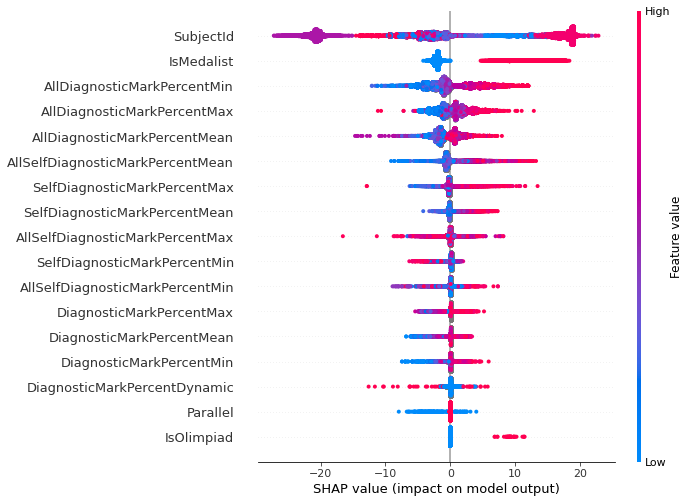

In [100]:
shap_test = shap.TreeExplainer(model).shap_values(X)
shap.summary_plot(shap_test, X, max_display=25)

# Questions